# Importing modules

Let's first add these libraries to our project:

`numpy`: for matrix operations

`tensorlfow`: deep learning layers

`maplotlitb`: visualization

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py as h5'
from tensorflow.python.framework import ops
from os import path
import os

# Steps for solving the problem

<ol>
    <li>Read data and format it.</li>
    <li>Use sliding window approach to augment data.</li>
    <li>Split data into training/dev/test sets.</li>
    <li>Create procedure for randomly initializing parameters with specified shape using Xavier's initialization.</li>
    <li>Create convolution and pooling procedures.</li>
    <li>Implement forward propagation.</li>
    <li>Implement cost function.</li>
    <li>Create model (uses Adam optimizer for minimization).</li>
    <li>Train model.</li>
    <li>Hyperparameter tuning using cross-validation sets.</li>
    <li>Retrain model until higher accuracy is achevied.</li>
</ol>

# Reading data

Use `dataset_relative_path` to point to the directory where the dataset after processing has been stored. 

In [178]:
dataset_relative_path = 'dataset/random-iter-5/'

In [179]:
datafile = dataset_relative_path + 'datafile1024.h5'

with h5.File(datafile, 'r') as datafile:
    X_train = np.array(datafile['X_train'])
    Y_train = np.array(datafile['Y_train'])
    
    X_dev = np.array(datafile['X_dev'])
    Y_dev = np.array(datafile['Y_dev'])
    
    X_test = np.array(datafile['X_test'])
    Y_test = np.array(datafile['Y_test'])

In [180]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [181]:
X_train = make_dimensions_compatible(X_train)
X_dev = make_dimensions_compatible(X_dev)
X_test = make_dimensions_compatible(X_test)

In [182]:
print(X_train.shape)
print(Y_train.shape)

(11250, 1024, 1)
(11250, 3)


### Normalization

It is a standard procedure to use normalization formula that subtracts by mean and divides by standard deviation. However, for the purpose of simplicity it won't hurt the performance of the models too much to just divide by 1000 since most of the data points are voltage measures with values ranging significantly within -1000 and 1000.

In [183]:
X_train = X_train / 1000
X_dev = X_dev / 1000
X_test = X_test / 1000

# Initialization

Deep neural networks suffer from a problem of exploding or vanishing gradients. To reduce the effect, we use Xavier's initialization which is already built into the Tensorflow.

`intiialize_parameters` receives the shapes and values of different parameters and hyper parameters to be initialized.

In [10]:
def initialize_parameters(parameter_shapes, parameter_values = {}):
    """
    Initializes weight parameters to build a neural network with tensorflow using Xaviar's initialization.
    The parameters are:
    parameter_shapes: a dictionary where keys represent tensorflow variable names, and values
    are shapes of the parameters in a list format
    Returns:
    params -- a dictionary of tensors containing parameters
    """
    
    params = { }
    
    for n,s in parameter_shapes.items():
        param = tf.get_variable(n, s, initializer = tf.contrib.layers.xavier_initializer())
        params[n] = param
    
    for n,v in parameter_values.items():
        params[n] = v
    
    return params

# Forward Propagation

Forward propagation builds most of the computation graph of the models and defines the layers for each model.

For models with different set of layers or different architecture, we define different forward propagation function. Models having similar architecture and which only differ by parameter shapes or hyper parameters share common function.

The architectures of the models we trained are described in the literature of this project.

In [9]:
def forward_propagation_cnn1(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output
    

In [10]:
def forward_propagation_cnn3(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU DROPOUT) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    # Dropout
    A2_dropped = tf.contrib.layers.dropout(A2, keep_prob=DO_prob_middle_layer, is_training=training)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2_dropped, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [11]:
def forward_propagation_cnn8(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    # Flatten activations for FC layer
    A2_flat = tf.contrib.layers.flatten(A2)
    
    # Layer 3
    # FC
    A3 = tf.contrib.layers.fully_connected(A2_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A3_dropped = tf.contrib.layers.dropout(A3, keep_prob=DO_prob, is_training=training)
    
    # Layer 4
    # FC
    logits = tf.contrib.layers.fully_connected(A3_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

# Computing cost function

We use cross entropy loss for our classification problem which takes logits from forward propagation as one of its input. The softmax layer's output from forward propagation functions defined above is not used for computing cost and is used for making predictions at the end of this notebook. The cost function of cross entropy which is built in the Tensorflow computes its own softmax.

In [12]:
def compute_cost(X, Y, parameters, nn_key, training):
    
    """
    Apply softmax to the output classes and find cross entropy loss
    X - Input data
    Y - One-hot output class training labels
    
    Returns:
    cost - cross entropy loss
    """
    
    # FIXME: setting training=training causes problems during evaluation time
    if nn_key == 'cnn1':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn2':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn3':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn4':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn5':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn6':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn7':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn8':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    else:
        KeyError('Provided nn_key doesn\'t match with any model')
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    
    return cost, Y_hat

# Pre-requisites for training

Here are some procedures that are necessary to execute before the actual training.

### Create placeholders

Tensorflow functions take input in the form of `feed_dict`. The variables in other functions are placeholders for the actual input.

In [13]:
def create_placeholders(n_x, n_y):
    """
    Creates Tensorflow placeholders that act for input data and their labels
    
    Arguments:
    n_x - no. of features for X
    n_x - no. of classes for Y
    
    Returns:
    X - placeholder for data that contains input featurs,
        shape: (no. of examples, no. of features). No. of examples is set to None
    Y - placeholder for data that contains output class labels,
        shape (no. of examples, no. of classes). No. of examples is set ot None
    """
    
    X = tf.placeholder(tf.float32, name='X', shape=(None, n_x, 1))
    Y = tf.placeholder(tf.float32, name='Y', shape=(None, n_y))
    is_train = tf.placeholder(tf.bool, name='is_train')
    
    return X,Y,is_train

### Parameter shapes

To initialize model parameters, we've created a procedure above. It takes as an argument a dictionary in which we supply the model parameter shapes.

In [14]:
def parameter_shapes(nn_key):
    """
    Get tha shapes of all parameters used in the model.
    Convolutional layer parameter shapes (filters) are in list format
    
    Arguments:
    nn_key - Provide the key for the neural network model used
    could be, 'cnn1', 'cnn2'
    
    Returns:
    param_shapes - dict that contains all the parameters as follows
    CONV1_W, CONV2_W, CONV3_W
    param_values:
    CONV1_Str, CONV2_Str, CONV3_Str,
    FC1_units, DO_prob, output_classes
    """
    
    param_shapes = {}
    param_values = {}
    
    do_prob = {
        'cnn1': 0.5,
        'cnn2': 0.3,
        'cnn3': 0.3,
        'cnn4': 0.9,
        'cnn5': 0.5,
        'cnn6': 0.7,
        'cnn7': 0.3,
        'cnn8': 0.3
    }
    
    do_prob_middle_layer = {
        'cnn1': 0,   # not used
        'cnn2': 0,   # not used
        'cnn3': 0.8,
        'cnn4': 0,   # not used
        'cnn5': 0,   # not used
        'cnn6': 0,   # not used
        'cnn7': 0,   # not used
        'cnn8': 0    # not used
    }
    
    fc1_units = {
        'cnn1': 20,
        'cnn2': 15,
        'cnn3': 15,
        'cnn4': 15,
        'cnn5': 20,
        'cnn6': 15,
        'cnn7': 15,
        'cnn8': 10
    }

    # Conv Layer 1 parameter shapes
    # No. of channels: 24, Filter size: 5, Stride: 3
    param_shapes['CONV1_W'] = [5, 1, 24]
    param_values['CONV1_Str'] = 3
    
    # Conv Layer 2 parameter shapes
    # No. of channels: 16, Filter size: 3, Stride: 2
    param_shapes['CONV2_W'] = [3, 24, 16]
    param_values['CONV2_Str'] = 2
    
    # Dropout after the convolutional layer 2
    # Not used in some cases
    param_values['DO_prob_middle_layer'] = do_prob_middle_layer[nn_key]
    
    # Conv Layer 3 parameter shapes
    # No. of channels: 8, Filter size: 3, Stride: 2
    param_shapes['CONV3_W'] = [3, 16, 8]
    param_values['CONV3_Str'] = 2
    
    # Fully connected layer 1 units = 20
    param_values['FC1_units'] = fc1_units[nn_key]
    
    # Dropout layer after fully connected layer 1 probability
    param_values['DO_prob'] = do_prob[nn_key]
    
    # Fully connected layer 2 units (also last layer)
    # No. of units = no. of output classes = 3
    param_values['output_classes'] = 3
    
    return param_shapes, param_values

### Random mini-batches

For each epoch we'll use different sets of mini-batches to avoid any possible overfitting.

In [15]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, window size) (m, n_x)
    Y -- output classes, of shape (number of examples, output classes) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Plotting costs

At the end of each training session, we'll plot the learning curves for training and dev sets.

In [16]:
def plot_costs(costs, dev_costs, learning_rate, total_epochs):
    # plot the cost
    plt.plot(costs, color='blue', label='training')
    plt.plot(dev_costs, color='green', label='dev')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = %f\nTotal Epochs = %i" % (learning_rate, total_epochs))
    plt.legend()
    plt.show()

# Training data

WRITE TEXT HERE...

[UPDATE_OPS](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm)

In [17]:
def model(X_train, Y_train, X_dev, Y_dev,
          learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True,
          save_session_path=None, model_file=None, restore_session=False, save_session_interval=5, max_to_keep=10,
          nn_key='cnn1'):
    """
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x,_) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    dev_costs = []
    
    model_path = None
    if (save_session_path != None and model_file != None):
        model_path = save_session_path + model_file
    
    
    # Create Placeholders of the correct shape
    X, Y, is_train = create_placeholders(n_x, n_y)

    # Initialize parameters
    param_shapes, param_values = parameter_shapes(nn_key)
    parameters = initialize_parameters(param_shapes, param_values)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Prediction: Use Y_hat to compute the output class during prediction
    cost, Y_hat = compute_cost(X, Y, parameters, nn_key, is_train)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # For saving / restoring sesison when training for long
    epoch_counter = tf.get_variable('epoch_counter', shape=[], initializer=tf.zeros_initializer)
    counter_op = tf.assign_add(epoch_counter, 1)
    saver = tf.train.Saver(max_to_keep=max_to_keep)
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Y_hat, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # For impementation of batch norm the tf.GraphKeys.UPDATE_OPS dependency needs to be added
    # see documentation on tf.contrib.layers.batch_norm
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess: #, tf.control_dependencies(update_ops):
        
        if (restore_session == False and path.exists(save_session_path)):
            raise FileExistsError('Session already exists, either restore the session, or manually delete the files.')
        
        # restore the previous session if the path already exists
        if (model_path != None and restore_session==True):
            print("Restoring session...\n")
            saver.restore(sess, model_path)
            print("Previous epoch counter: %i\n\n" % epoch_counter.eval())
        else:
            sess.run(init)
        
        tf.train.export_meta_graph(model_path + '.meta') # save the model file (.meta) only once
        
        print("Cost at start: %f" % cost.eval({X: X_train, Y: Y_train, is_train: False}))
        print("Dev cost: %f" % cost.eval({X: X_dev, Y: Y_dev, is_train: False}))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                
                try:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, is_train: True})

                    epoch_cost += minibatch_cost / num_minibatches
                
                # Implement early stopping mechanism on KeyboardInterrupt
                except KeyboardInterrupt:
                    print("KeyboardInterrupt received. Stopping early")
                    plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())
                    return parameters
                
            
            if (epoch % save_session_interval == 0 and save_session_path != None):
                saver.save(sess, model_path, write_meta_graph=False)
            
            # Save the costs after each epoch for plotting learning curve
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                dev_cost = cost.eval({X: X_dev, Y: Y_dev, is_train: False})
                dev_costs.append(dev_cost)
                
                
            # Print the cost every epoch
            if print_cost == True and (epoch + 1) % 5 == 0:
                print ("\nCost after epoch %i: %f" % (epoch + 1, epoch_cost))
                print ("Dev cost after epoch %i: %f" % (epoch + 1, dev_cost))
                
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
                dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
                print("Train Accuracy:", train_accuracy)
                print("Dev Accuracy:", dev_accuracy)
            
            # increment the epoch_counter in case the session is saved
            # and restored later
            sess.run(counter_op)
                
                
        if (save_session_path != None):
            saver.save(sess, model_path, write_meta_graph=False)
        
        
        plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())

        # Calculate the correct predictions
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
                
        return parameters
    
    

Cost at start: 1.097090
Dev cost: 1.097712
Train Accuracy: 0.27711502
Dev Accuracy: 0.28266665

Cost after epoch 5: 0.856150
Dev cost after epoch 5: 1.045593
Train Accuracy: 0.40194932
Dev Accuracy: 0.4

Cost after epoch 10: 0.685988
Dev cost after epoch 10: 1.078506
Train Accuracy: 0.43590644
Dev Accuracy: 0.44533333

Cost after epoch 15: 0.569552
Dev cost after epoch 15: 0.975862
Train Accuracy: 0.5325926
Dev Accuracy: 0.5786667

Cost after epoch 20: 0.522651
Dev cost after epoch 20: 0.690352
Train Accuracy: 0.6983236
Dev Accuracy: 0.704

Cost after epoch 25: 0.494121
Dev cost after epoch 25: 0.455851
Train Accuracy: 0.79157895
Dev Accuracy: 0.808

Cost after epoch 30: 0.467195
Dev cost after epoch 30: 0.384743
Train Accuracy: 0.84050685
Dev Accuracy: 0.824

Cost after epoch 35: 0.454066
Dev cost after epoch 35: 0.357368
Train Accuracy: 0.8659649
Dev Accuracy: 0.82133335

Cost after epoch 40: 0.429714
Dev cost after epoch 40: 0.334755
Train Accuracy: 0.88038987
Dev Accuracy: 0.837333

Train Accuracy: 0.97676414
Dev Accuracy: 0.9493333

Cost after epoch 360: 0.141160
Dev cost after epoch 360: 0.117455
Train Accuracy: 0.977232
Dev Accuracy: 0.94666666

Cost after epoch 365: 0.135125
Dev cost after epoch 365: 0.112906
Train Accuracy: 0.9773879
Dev Accuracy: 0.9493333

Cost after epoch 370: 0.137728
Dev cost after epoch 370: 0.117344
Train Accuracy: 0.9782456
Dev Accuracy: 0.952

Cost after epoch 375: 0.138612
Dev cost after epoch 375: 0.125593
Train Accuracy: 0.9779337
Dev Accuracy: 0.952

Cost after epoch 380: 0.133496
Dev cost after epoch 380: 0.117837
Train Accuracy: 0.97820663
Dev Accuracy: 0.9546667

Cost after epoch 385: 0.132045
Dev cost after epoch 385: 0.108487
Train Accuracy: 0.9777778
Dev Accuracy: 0.9573333

Cost after epoch 390: 0.131996
Dev cost after epoch 390: 0.119406
Train Accuracy: 0.97875243
Dev Accuracy: 0.9493333

Cost after epoch 395: 0.128732
Dev cost after epoch 395: 0.119744
Train Accuracy: 0.9793762
Dev Accuracy: 0.9493333

Cost after epoch 4

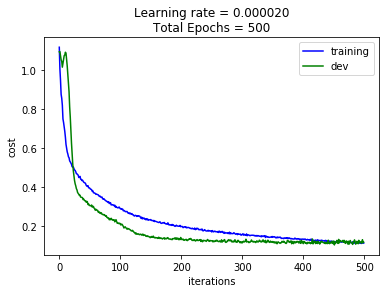

Train Accuracy: 0.9836647
Dev Accuracy: 0.9546667


In [21]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn11_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn11')

# Prediction and restoring saved model

In [11]:
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        is_train = graph.get_tensor_by_name('is_train:0')
        
        epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
        print(epoch_counter.eval())

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            print('Accuracy: %f' % (y_hat_test == y_test).mean())
        

    return y_hat_test


In [12]:
def predict_voting(X_test_voting, session_path, model_file):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file
    
    y_hat_test_voting = []

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        is_train = graph.get_tensor_by_name('is_train:0')

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.gather(classname, tf.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [190]:
predictions = predict(X_dev, 'train/dataset-1024-6/cnn6_lr-0.00002_mbs-128/', 'model.meta', Y_test_onehot=Y_dev)

print("\nPredicted values:")
print(predictions)

print("\nActual values:")
print(np.argmax(Y_test, 1))

INFO:tensorflow:Restoring parameters from train/dataset-1024-6/cnn6_lr-0.00002_mbs-128/model
500.0
Accuracy: 0.994286

Predicted values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Actual values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


# Evaluating test set for accuracy with voting

In [184]:
testfile = dataset_relative_path + 'testset_voting_1024.h5'
session_path = 'train/dataset-1024-5/cnn6_lr-0.00002_mbs-128/'
model_file = 'model.meta'

with h5.File(testfile, 'r') as testfile:
    X_test_voting = testfile['X']
    X_test_voting = np.array(X_test_voting) / 1000
    y_test_voting = np.array(testfile['Y'])
    
    y_hat_test_voting = predict_voting(X_test_voting, session_path, model_file)
    
    print("Accuracy with voting: %f" % (y_test_voting == y_hat_test_voting).mean())
    

INFO:tensorflow:Restoring parameters from train/dataset-1024-5/cnn6_lr-0.00002_mbs-128/model
Accuracy with voting: 0.960000


In [ ]:
print(y_hat_test_voting)
print(y_test_voting)

In [244]:
np.mean([[95.67, 90.7, 93.3, 93.3],
         [95.7, 89.8, 99.2, 93.6],
         [96, 89.3, 93.3, 93.6],
         [0, 0, 0, 0],
         [96.27, 90.9, 93.3, 93.9],
         [94.9, 91.4, 95.2, 96.5],
         [96.27, 89, 93.3, 93.8],
         [93.9, 97.8, 97.3, 98.1]
        ], axis=1)

array([98.775, 98.975, 98.925,  0.   , 98.725, 98.65 , 98.525, 98.025])

In [193]:
np.std([100,100,100,100,98])

0.8

In [194]:
np.mean([100,100,100,100,98])

99.6